# **MLP - Boston House Prices Dataset**

## [Step 01] 라이브러리 로딩

In [ ]:
# Import libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# T4(Turing 아키텍처), P100, V100(Volta 아키텍처), A100(Ampere 아키텍처)
!nvidia-smi

Tue Feb  7 15:21:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## [Step 02] 데이터셋 로딩

In [ ]:
# Import dataset and download boston dataset
# https://scikit-learn.org/stable/datasets/toy_dataset.html
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings('ignore')

boston = load_boston()

In [ ]:
boston

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [ ]:
# boston.DESCR = boston['DESCR']
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [ ]:
# The shape of Boston data and feature_names
print(type(boston.data))
print(boston.data.shape)
print(boston.feature_names)

<class 'numpy.ndarray'>
(506, 13)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


## [Step 03] 데이터 분석
- EDA(Exploratory Data Analysis, 탐색적 데이터 붅석)
- 데이터를 분석하기 전 그래프나 통계적인 방법으로 자료를 직관적으로 이해하는 과정

### Pandas를 활용한 데이터 출력

> https://pandas.pydata.org/



In [ ]:
import pandas as pd

# Boston 데이터셋 Dataframe 변환
df = pd.DataFrame(boston.data, columns=boston.feature_names)

#df.columns = boston.feature_names

# 앞 10개의 데이터를 출력
df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [ ]:
boston['target']

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [ ]:
# Target array로 price 추가
df['PRICE'] = boston.target

# 앞 5개의 데이터를 출력
df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
# 데이터 요약 출력
# 백분위수(k-th percentile) - 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [ ]:
df.describe(percentiles=[0.01, 0.05, 0.99])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
1%,0.013610,0.000000,1.253500,0.000000,0.398000,4.524450,6.610000,1.206540,1.000000,188.000000,13.000000,6.730000,2.883000,7.010000
5%,0.027910,0.000000,2.180000,0.000000,0.409250,5.314000,17.725000,1.461975,2.000000,222.000000,14.700000,84.590000,3.707500,10.200000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
99%,41.370330,90.000000,25.650000,1.000000,0.871000,8.335000,100.000000,9.222770,24.000000,666.000000,21.200000,396.900000,33.918500,50.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


### Seaborn을 활용한 데이터 가시화


> https://seaborn.pydata.org/



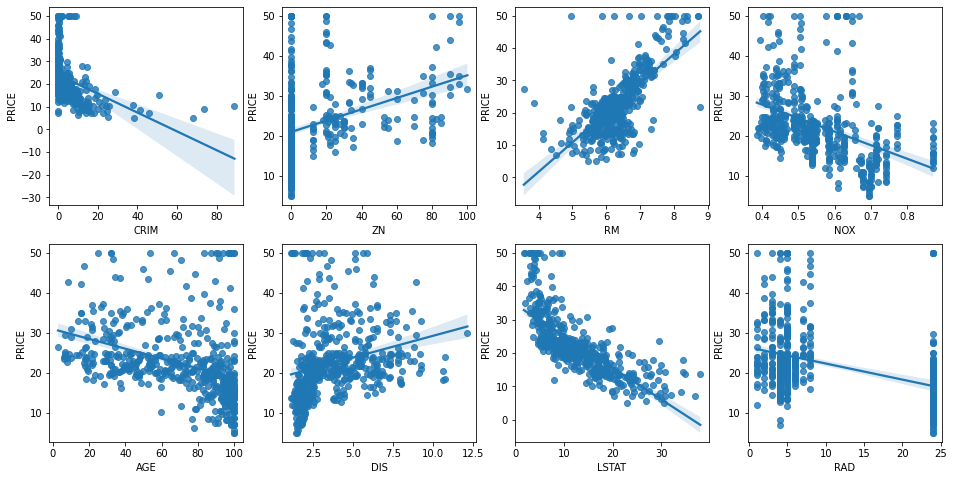

In [ ]:
import seaborn as sns

# 2x4 subplot 이용. axs는 4x2
fig, axes = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
features = ['CRIM','ZN','RM','NOX','AGE','DIS','LSTAT','RAD']

for i, feature in enumerate(features):
    row = int(i/4)
    col = i%4

    # Plot data and a linear regression model fit
    sns.regplot(x=feature, y='PRICE', data=df, ax=axes[row][col])

## [Step 04] 데이터 클래스 생성

In [ ]:
# 데이터프레임을 넘파이 배열로 만들기
X = df.drop('PRICE', axis=1).to_numpy()
Y = df['PRICE'].to_numpy().reshape((-1, 1))
print(X.shape)
print(Y.shape)

(506, 13)
(506, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 스케일링, sklearn에서 제공하는 MinMaxScaler를 활용, (X-min(X))/(max(X)-min(X))
scaler = MinMaxScaler()

scaler.fit(X)
X = scaler.transform(X)
scaler.fit(Y)
Y = scaler.transform(Y)

In [ ]:
# 텐서 데이터 클래스 선언
class TensorData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 나누기(train and test data)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
print(len(X_train))
print(len(X_test))

354
152


In [ ]:
# 학습 데이터, 시험 데이터 배치 형태로 구축하기
train_sets = TensorData(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_sets, batch_size=32, shuffle=True)

test_sets = TensorData(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_sets, batch_size=32, shuffle=False)

## [Step 05] MLP 모델 정의

In [46]:
class MLP(nn.Module):
    def __init__(self):

        # Define the deep neural network and dropout
        super().__init__()
        self.fc1 = nn.Linear(13, 50, bias=True)
        self.fc2 = nn.Linear(50, 30, bias=True)
        self.fc3 = nn.Linear(30, 1, bias=True)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))

        return x

## [Step 06] 네트워크 학습

In [ ]:
# 모델, 손실함수, 최적화 선언
model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

# 학습 진행
loss_ = []
for epoch in range(400):

    # Loss for each epoch
    running_loss = 0.0

    # Inputs: 32 batch size data
    for i, data in enumerate(train_loader, 0):

        inputs, values = data

        # Optimizer - 매번 초기화 with zero_grad()
        optimizer.zero_grad()

        # 모델 예측값 outputs(32개 - bathch size)
        outputs = model(inputs)

        # Loss function 계산
        loss = criterion(outputs, values)
        
        # Backpropagation
        loss.backward()

        # model.parameter()의 weight를 업데이트
        optimizer.step()

        running_loss += loss.item()

    # MSE(Mean Squared Error) 계산
    loss_.append(running_loss / len(train_loader))
    print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))
    
plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

## [Step 07] 결과 가시화

[0.41243172]
[0.37777779]


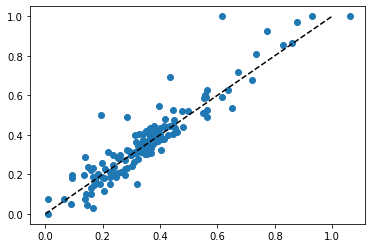

In [ ]:
y_pred = []
y_true = []
model.train(False)
for i, data in enumerate(test_loader, 0):
    inputs, values = data
    y_pred.extend(model(inputs).data.numpy())
    y_true.extend(values.numpy())
plt.scatter(y_pred, y_true)
plt.plot([0, 1], [0, 1], '--k')

print(y_pred[5])
print(y_true[5])

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("MAE:", mean_absolute_error(y_true, y_pred))
print("MSE:", mean_squared_error(y_true, y_pred))
print("R^2:", r2_score(y_true, y_pred))

MAE: 0.046001554
MSE: 0.0048929397
R^2: 0.8662655458960448
